# 1. Augmentation 을 적용한 데이터셋 만들기

In [1]:
# 필요 라이브러리 임포트

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import urllib3
urllib3.disable_warnings()

In [2]:
# GPU 사용환경 확인

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 데이터 가져오기

(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', 
                                         split = ['train', 'test'], 
                                         shuffle_files = True, 
                                         with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


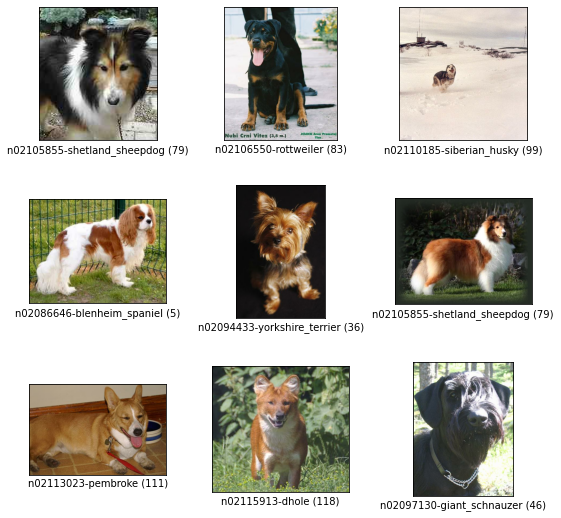

In [4]:
# 데이터 샘플 살펴보기

fig = tfds.show_examples(ds_train, ds_info)

In [5]:
# augmentation 적용을 위한 전처리 함수

# 이미지 변환을 위한 전처리 함수 형태
'''
def 전처리_함수(image, label):   # 변환할 이미지와 
    # 이미지 변환 로직 적용
    new_image = 이미지_변환(image)
    return new_image, label
'''

def normalize_and_resize_img(image, label):
    """Normalizes images: uint8 -> float32"""
    
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
# augmentation 적용을 위한 전처리 함수

# 이미지 변환을 위한 전처리 함수 형태
'''
def 전처리_함수(image, label):   # 변환할 이미지와 
    # 이미지 변환 로직 적용
    new_image = 이미지_변환(image)
    return new_image, label
'''

def normalize_and_resize_img(image, label):
    """Normalizes images: uint8 -> float32"""
    
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
# random_augmentation 중 random_flip_left_right() 와 random_brightness() 적용

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta = 0.2)
    
    return image,label

In [8]:
# apply_normalize_on_dataset() : 다양한 형태로 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현하는 메인 함수

# 일반적인 전처리 과정 (normalize, resize, augmentation, shuffle 적용)
# shiffle, augmentation 은 테스트 데이터셋에는 적용하지 않아야 한다.


# 데이터셋을 가공하는 메인함수 (with_aug 매개변수를 통해 augmentation 적용 여부를 결정)
def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16, with_aug = False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls = 2
    )
    if not is_test and with_aug:
        ds = ds.map(augment, num_parallel_calls=2)
    
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [9]:
# Random Augmentation 직접 구현

# tf.image 의 함수를 이용하여 구현

def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))    # 50%의 확률로 이미지 가운데 부분을 crop합니다.
    image = tf.image.resize(image, INPUT_SHAPE)    # crop한 이미지를 원본 사이즈로 resize
    
    return image, label

In [10]:
# Augumentation 을 적용한 데이터를 학습한 모델과 적용하지 않은 데이터를 학습한 모델의 성능 비교

# keras 의 ResNet50 중 imagenet 에 훈련도니 모델을 불러온다.
# include_top 은 마지막 fully connected layer 를 포함할지 여부
# 해당 레이어를 포함하지 않고 생성하면 feature extractor (특성 추출기) 부분만 불러와 
# 필요에 맞게 수정된 fully connected layer 를 붙여 활용 가능
# imagemet 과 테스트셋이 서로 다른 클래스를 가지기 때문에
# 마지막에 추가해야하는 fully connect layer 의 구조 (뉴런의 개수) 또한 다르다.

num_classes = ds_info.features['label'].num_classes

resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                       weights = 'imagenet', 
                                                                       input_shape = (224, 224, 3), 
                                                                       pooling = 'avg'), 
                                    keras.layers.Dense(num_classes, activation = 'softmax')])

94773248/94765736 [==============================] - 1s 0us/step


In [11]:
# Augmentation 을 적용한 데이터셋으로 학습시킬 ResNet 생성

aug_resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                          weights = 'imagenet', 
                                                                          input_shape = (224, 224, 3), 
                                                                          pooling = 'avg'), 
                                       keras.layers.Dense(num_classes, activation = 'softmax')])

In [12]:
# 텐서플로우 데이터에서 불러온 데이터에 apply_normalize_on_dataset() 에
# 하나는 with_aug 를 False 로,
# 다른 하나는 with_aug 를 True 로 설정

(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', 
                                         split = ['train', 'test'], 
                                         as_supervised = True, 
                                         shuffle_files = True, 
                                         with_info = True)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug = False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug = True)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [13]:
# 각각의 모델 학습

EPOCH = 20

tf.random.set_seed(2020)
resnet50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

aug_resnet50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

Epoch 1/20
750/750 [==============================] - 368s 441ms/step - loss: 3.1935 - accuracy: 0.2808 - val_loss: 3.3402 - val_accuracy: 0.2226
Epoch 2/20
750/750 [==============================] - 349s 465ms/step - loss: 0.8979 - accuracy: 0.7548 - val_loss: 1.0650 - val_accuracy: 0.6890
Epoch 3/20
750/750 [==============================] - 326s 434ms/step - loss: 0.3010 - accuracy: 0.9330 - val_loss: 0.9626 - val_accuracy: 0.7204
Epoch 4/20
750/750 [==============================] - 326s 435ms/step - loss: 0.0849 - accuracy: 0.9903 - val_loss: 0.9152 - val_accuracy: 0.7383
Epoch 5/20
750/750 [==============================] - 327s 436ms/step - loss: 0.0306 - accuracy: 0.9988 - val_loss: 0.9390 - val_accuracy: 0.7346
Epoch 6/20
750/750 [==============================] - 328s 438ms/step - loss: 0.0194 - accuracy: 0.9994 - val_loss: 0.9291 - val_accuracy: 0.7409
Epoch 7/20
750/750 [==============================] - 343s 457ms/step - loss: 0.0136 - accuracy: 0.9993 - val_loss: 0.9395 -

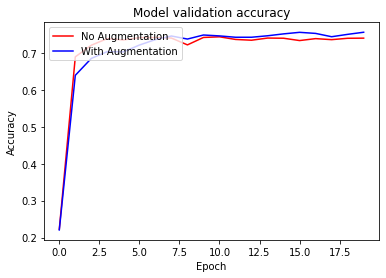

In [14]:
# 훈련과정 시각화

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

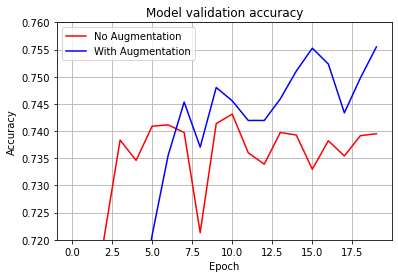

In [15]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()


## CutMix 이미지 섞기

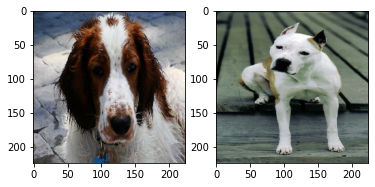

In [16]:
# CutMix 이미지 섞기

# 데이터 셋에서 2개의 이미지 가져오기

for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [17]:
# 첫번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두번째 이미지 b가 있을 때, 
# a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수 구현

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width // 2)
    ya = tf.math.maximum(0, y-height // 2)
    xb = tf.math.minimum(image_size_x, x+width // 2)
    yb = tf.math.minimum(image_size_y, y+width // 2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(65, shape=(), dtype=int32) tf.Tensor(88, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


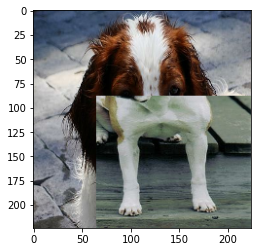

In [18]:
# 바탕이미지 a에서 바운딩 박스 바깥쪽 영역을, 
# 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수 구현

# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis = 1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis = 0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

## CutMix 라벨 섞기

In [19]:
# CutMix 라벨 섞기

# 섞인 이미지에 대해 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수 구현

# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa) * (yb-ya)
    total_area = image_size_x * image_size_y
    a = tf.cast(mixed_area / total_area, tf.float32)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.430963  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.56903696, 0.        , 0.        ,
       0.     

## CutMix 함수 구현

In [20]:
# 위에서 구현한 함수를 통해 배치 단위의 CutMix 함수 구현

def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_label

## MixUp 함수 구현

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.4470563 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.5529437 0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

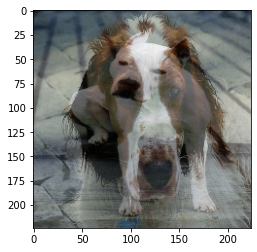

In [21]:
# MixUp Augmentation

# function for mixup

def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a) * image_a + a * image_b
    mixed_label = (1-a) * label_a + a * label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [22]:
# 배치단위의 MixUp 함수 구현

def mixup(image, label, prob = 1.0, batch_size = 16, img_size = 224, num_classes = 120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [29]:
# apply_normalize_on_dataset() : 다양한 형태로 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현하는 메인 함수

# 일반적인 전처리 과정 (normalize, resize, augmentation, shuffle 적용)
# shiffle, augmentation 은 테스트 데이터셋에는 적용하지 않아야 한다.


# 데이터셋을 가공하는 메인함수 (with_aug 매개변수를 통해 augmentation 적용 여부를 결정)

def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16, with_aug = False, with_cutmix = False, with_mixup = False):
    
    ds = ds.map(normalize_and_resize_img, num_parallel_calls = 2)
    
    if not is_test and with_aug:
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls = 2)
        
    elif not is_test and with_mixup : 
        ds = ds.map(mixup, num_parallel_calls = 2)
        
    else:
        ds = ds.map(onehot, num_parallel_calls = 2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [30]:
# onehot 인코딩

def onehot(image, label, num_classes = 120) : 
    label = tf.one_hot(label, num_classes)
    
    return image, label

# 2. 모델 만들기

In [31]:
# Augumentation 을 적용한 데이터를 학습한 모델과 적용하지 않은 데이터를 학습한 모델의 성능 비교

# keras 의 ResNet50 중 imagenet 에 훈련도니 모델을 불러온다.
# include_top 은 마지막 fully connected layer 를 포함할지 여부
# 해당 레이어를 포함하지 않고 생성하면 feature extractor (특성 추출기) 부분만 불러와 
# 필요에 맞게 수정된 fully connected layer 를 붙여 활용 가능
# imagemet 과 테스트셋이 서로 다른 클래스를 가지기 때문에
# 마지막에 추가해야하는 fully connect layer 의 구조 (뉴런의 개수) 또한 다르다.

num_classes = ds_info.features['label'].num_classes

resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                       weights = 'imagenet', 
                                                                       input_shape = (224, 224, 3), 
                                                                       pooling = 'avg'), 
                                    keras.layers.Dense(num_classes, activation = 'softmax')])

In [32]:
# Augmentation + cutmix 을 적용한 데이터셋으로 학습시킬 ResNet 생성

aug_cm_resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                          weights = 'imagenet', 
                                                                          input_shape = (224, 224, 3), 
                                                                          pooling = 'avg'), 
                                       keras.layers.Dense(num_classes, activation = 'softmax')])

In [33]:
# Augmentation + mixup 을 적용한 데이터셋으로 학습시킬 ResNet 생성

aug_mu_resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                          weights = 'imagenet', 
                                                                          input_shape = (224, 224, 3), 
                                                                          pooling = 'avg'), 
                                       keras.layers.Dense(num_classes, activation = 'softmax')])

In [34]:
# 텐서플로우 데이터에서 불러온 데이터에 apply_normalize_on_dataset() 에
# 하나는 with_aug 를 False 로,
# 다른 하나는 with_aug 를 True 로 설정

(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', 
                                         split = ['train', 'test'], 
                                         as_supervised = True, 
                                         shuffle_files = True, 
                                         with_info = True)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug = False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug = True)
ds_train_aug_cm = apply_normalize_on_dataset(ds_train, with_cutmix = True)
ds_train_aug_mu = apply_normalize_on_dataset(ds_train, with_mixup = True)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

# 3. CutMix 와 Mixup 적용한 모델 훈련하기

In [ ]:
# 최신 기법(CutMix 와 Mixup)을 적용한 모델 학습

EPOCH = 20

tf.random.set_seed(2020)
resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

aug_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

aug_cm_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

aug_mu_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])


# CutMix
history_resnet50_aug_cm = aug_cm_resnet50.fit(
    ds_train_aug, # 기본 augmentation + cutmix 적용한 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

# Mixup
history_resnet50_aug_mu = aug_mu_resnet50.fit(
    ds_train_aug, # 기본 augmentation + mixup 적용한 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

Epoch 1/20
750/750 [==============================] - 335s 436ms/step - loss: 3.2152 - accuracy: 0.2691 - val_loss: 3.1382 - val_accuracy: 0.2533
Epoch 2/20
750/750 [==============================] - 326s 434ms/step - loss: 1.0375 - accuracy: 0.7029 - val_loss: 1.2237 - val_accuracy: 0.6430
Epoch 3/20
750/750 [==============================] - 326s 434ms/step - loss: 0.5523 - accuracy: 0.8478 - val_loss: 1.0724 - val_accuracy: 0.6906
Epoch 4/20
750/750 [==============================] - 330s 440ms/step - loss: 0.2597 - accuracy: 0.9407 - val_loss: 0.9849 - val_accuracy: 0.7192
Epoch 5/20
750/750 [==============================] - 343s 458ms/step - loss: 0.1347 - accuracy: 0.9756 - val_loss: 0.9364 - val_accuracy: 0.7354
Epoch 6/20
750/750 [==============================] - 325s 434ms/step - loss: 0.0709 - accuracy: 0.9896 - val_loss: 0.9690 - val_accuracy: 0.7284
Epoch 7/20
750/750 [==============================] - 325s 434ms/step - loss: 0.0427 - accuracy: 0.9959 - val_loss: 0.9503 -

# 4. 훈련과정 시각화하기

In [ ]:
fig = plt.figure(figsize=(16,4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug_cm.history['loss'], 'g')
plt.plot(history_resnet50_aug_mu.history['loss'], 'm')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')

# 5. Augmentation에 의한 모델 성능 비교

In [ ]:
# 훈련과정 시각화

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cm.history['val_accuracy'], 'o')
plt.plot(history_resnet50_aug_mu.history['val_accuracy'], 'x')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + CuxMix', 'With Augmentation + MixUp'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cm.history['val_accuracy'], 'o')
plt.plot(history_resnet50_aug_mu.history['val_accuracy'], 'x')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + CuxMix', 'With Augmentation + MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()